# Packages

In [2]:
from SignalProcessing import RangeCompression,DopplerProcessing,CFAR, Clustering
import Dataloader
import Plot
import numpy as np
from mmwave import dsp
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns; 
from matplotlib.colors import  LogNorm
from scipy.signal import butter, lfilter, freqz,detrend
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants
from scipy import ndimage
from PIL import Image, ImageFilter
from scipy.ndimage import convolve1d

from operator import itemgetter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# DataLoading

In [3]:
no_reflector = "felttest1/Record_2022-09-27_14-34-48/Record_2022-09-27_14-34-48.bin"
best_restult = "felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin"
munkholm = "felttest2/Record_2022-09-28_15-13-15/Record_2022-09-28_15-13-15.bin"

In [4]:
data_IF =Dataloader.LoadData("best_restult.npy")



# Algorithm

In [14]:
old=  RangeCompression.RangeCompression(data_IF[100,0],axis=1)
old, _ = DopplerProcessing.DopplerProcessing(old, axis=0,isClutterRemoval=True, removeArtifacts=False)
old= np.abs(old)

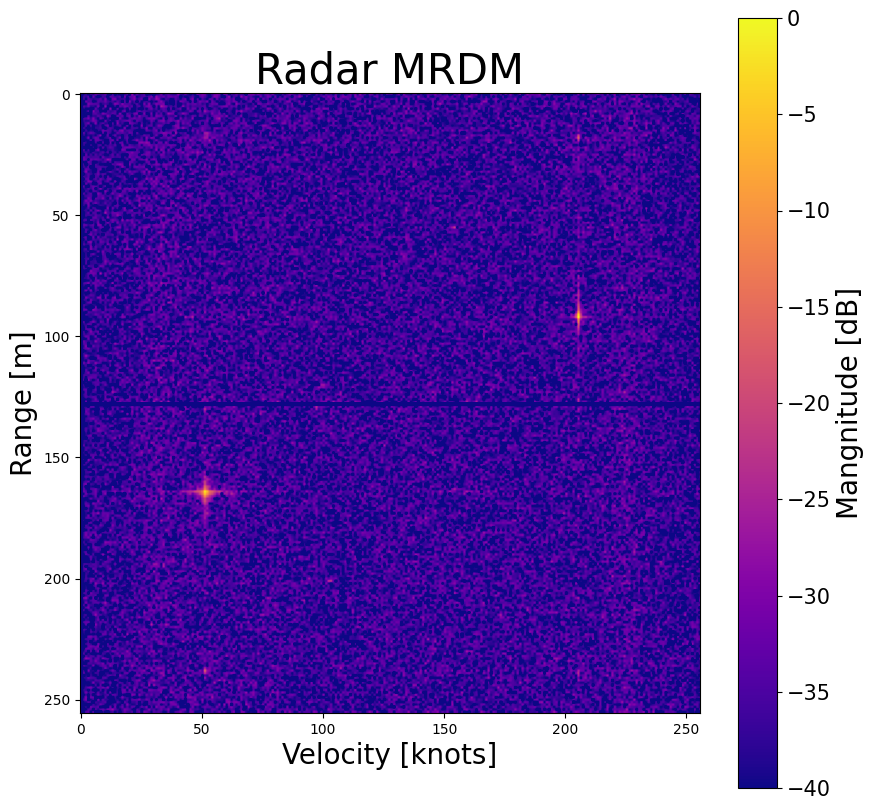

In [15]:
Plot.Plot(old, vmin=-40)

In [22]:
def P_avg(P,N):
    return P
def alpha(N,P_FA):
    return(P_FA**(-1/N)-1)

def estimated_teshold(alpha,P):
    return alpha*np.abs(P)


def CFAR_1D(data, guard_cells, training_cells, PFA):
    
    
    window_size = guard_cells + training_cells
    
    window_area = (2*window_size+1)**2
    training_area = training_cells*2
    a = alpha(training_area, PFA)

    kernel = np.ones((1 + (2 * guard_cells) + (2 * training_cells)), dtype=data.dtype)
    kernel[training_cells:training_cells + (2 * guard_cells) + 1] = 0
    
    res = convolve1d(data.copy(), kernel, mode='wrap')
    
    
    ret = (np.abs(data)>estimated_teshold(a,res))
    
    detections = np.argwhere(ret==True)
    #Transform cords to range and doppler
    #print(detections)
    

    detections = detections[detections[:,0] < 128,:] #delete all irelevant detections
    
    detections[:,1] = detections[:,1]*0.785277
    detections[:,0] = (128-detections[:,0])*-0.12755
  

    
    
    

    
    
            
    return ret,data*ret,detections

In [8]:
#Remove arifacts
argArtifacts = np.nonzero(old >4*np.mean(old[:,50]))

In [28]:
def algorithm_cfar_1d(data,argArtifacts):
    range_cube =  RangeCompression.RangeCompression(data,axis=1)
    linear, mag = DopplerProcessing.DopplerProcessing(range_cube, axis=0,isClutterRemoval=True)
    
    linear[argArtifacts] = 1e-10
    detections_map,P_detections,detections = CFAR_1D(np.abs(linear).copy(), 4, 8, 0.01)
    return P_detections,detections_map,detections

In [29]:
lin,cfar,detections=algorithm_cfar_1d(data_IF[401,0],argArtifacts)

In [ ]:
plt.plot(detections[:,1],detections[:,0],'o')   
plt.show()

In [11]:
lin[lin == 0]=1e-10

In [ ]:
Plot.PlotCFAR(np.abs(cfar))

In [34]:
cfar_arr=[]
for i in range(350,len(data_IF)):
    cfar_arr.append(algorithm_cfar_1d(data_IF[i,0],argArtifacts)[2])

# Tracking algo 

In [ ]:
def filter(z, updateNumber):
    dt = 0.1
    # Initialize State
    if updateNumber == 1:
        filter.x = np.array([[0],
                            [20]])
        filter.P = np.array([[5, 0],
                                 [0, 5]])
        filter.A = np.array([[1, dt],
                             [0, 1]])
        filter.H = np.array([[1, 0]])
        filter.HT = np.array([[1],
                              [0]])
        filter.R = 10
        filter.Q = np.array([[1, 0],
                             [0, 3]])
    # Predict State Forward
    x_p = filter.A.dot(filter.x)
    # Predict Covariance Forward
    P_p = filter.A.dot(filter.P).dot(filter.A.T) + filter.Q
    # Compute Kalman Gain
    S = filter.H.dot(P_p).dot(filter.HT) + filter.R
    K = P_p.dot(filter.HT)*(1/S)
    # Estimate State
    residual = z - filter.H.dot(x_p)
    filter.x = x_p + K*residual
    # Estimate Covariance
    filter.P = P_p - K.dot(filter.H).dot(P_p)
    return [filter.x[0], filter.x[1], filter.P]


def testFilter():
    dt = 0.1
    t = np.linspace(0, 10, num=300)
    numOfMeasurements = len(t)

    measTime = []
    measPos = []
    measDifPos = []
    estDifPos = []
    estPos = []
    estVel = []
    posBound3Sigma = []

    for k in range(1,numOfMeasurements):
        z = getMeasurement(k)
        # Call Filter and return new State
        f = filter(z[0], k)
        # Save off that state so that it could be plotted
        measTime.append(k)
        measPos.append(z[0])
        measDifPos.append(z[0]-z[1])
        estDifPos.append(f[0]-z[1])
        estPos.append(f[0])
        estVel.append(f[1])
        posVar = f[2]
        posBound3Sigma.append(3*np.sqrt(posVar[0][0]))

    return [measTime, measPos, estPos, estVel, measDifPos, estDifPos, posBound3Sigma];

In [70]:
import numpy as np
from scipy.linalg import inv
import time

class KalmanFilter(object):
    def __init__(self, dt, x_init, P_init, Q, R):
        self.dt = dt  # time step
        self.x = x_init  # initial state (position, velocity)
        self.P = P_init  # initial covariance matrix
        self.Q = Q  # process noise covariance
        self.R = R  # measurement noise covariance

    def predict(self, u=None):
        
        F = np.array([[1, self.dt], [0, 1]])  # state transition matrix
        if u is not None:
            B = np.array([[(self.dt**2)/2], [self.dt]])  # control input matrix
            self.x = F @ self.x + B @ u
                      
        else:
            self.x = F @ self.x
            
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):
        H = np.array([[1, 0], [0, 1]])  # observation matrix
       
        y = z - H @ self.x  # innovation
        print(y.shape)
        S = H @ self.P @ H.T + self.R  # innovation covariance
        print(S.shape)
        K = self.P @ H.T @ inv(S)  # Kalman gain
        print(K.shape)
        
        self.x = self.x + K @ y  # updated state estimate
        
        self.P = (np.eye(2) - K @ H) @ self.P  # updated covariance matrix

# Example usage
dt = 50*1e-3 # time step (in seconds)
x_init = np.array([[0], [5]])  # initial state (position, velocity)
P_init = np.diag([10, 10])  # initial covariance matrix

Q = np.diag([0.1, 0.1])  # process noise covariance
R = np.diag([[1,1],[1, 1]])  # measurement noise covariance
           
kf = KalmanFilter(dt, x_init, P_init, Q, R)

# Process measurement data
for k in cfar_arr:
    print(len(k))
    for i in range(len(k)):
        print("Update:", i)
        z = np.array([k[i][1],k[i][0]])  # current measurement (range, Doppler)
        print("Measurement:", z.T)
        kf.predict()
        kf.update(z)
        print("Estimated state:", kf.x,"\n")
        time.sleep(10)


15
Update: 0
Measurement: [160 -14]
(2, 2)
(2, 2)
(2, 2)
Estimated state: [[135.04505619 -11.36323332]
 [135.04505619 -11.36323332]] 

Update: 1
Measurement: [160 -13]
(2, 2)
(2, 2)
(2, 2)
Estimated state: [[148.04068944 -12.23425927]
 [148.04068944 -12.23425927]] 

Update: 2
Measurement: [160 -13]
(2, 2)
(2, 2)
(2, 2)
Estimated state: [[154.09440377 -12.65539665]
 [154.09440377 -12.65539665]] 

Update: 3
Measurement: [21 -7]
(2, 2)
(2, 2)
(2, 2)
Estimated state: [[116.81910711 -11.15941027]
 [116.81910711 -11.15941027]] 

Update: 4
Measurement: [124  -5]
(2, 2)
(2, 2)
(2, 2)
Estimated state: [[120.54350668  -9.70096257]
 [120.54350668  -9.70096257]] 

Update: 5
Measurement: [160  -4]
(2, 2)
(2, 2)
(2, 2)
Estimated state: [[132.24096302  -8.45237802]
 [132.24096302  -8.45237802]] 

Update: 6
Measurement: [160  -4]
(2, 2)
(2, 2)
(2, 2)
Estimated state: [[140.99242998  -7.54402648]
 [140.99242998  -7.54402648]] 

Update: 7
Measurement: [160  -4]
(2, 2)
(2, 2)
(2, 2)
Estimated state: [[14

KeyboardInterrupt: 

In [ ]:
def nearest_neighbor(observations, tracks, max_distance):
    """Performs nearest-neighbor data association between measurements and tracks.
    
    Parameters:
        observations (list): A list of observations in the form of (x, y) tuples.
        tracks (list): A list of tracks in the form of dictionaries, where each dictionary contains the following keys:
            - 'id': A unique identifier for the track.
            - 'x': The current x-coordinate of the track.
            - 'y': The current y-coordinate of the track.
        max_distance (float): The maximum distance between a measurement and a track for them to be associated.
    
    Returns:
        matches (list): A list of tuples in the form of (track_id, observation_index), where 'track_id' is the identifier
            of the associated track and 'observation_index' is the index of the associated observation in the 'observations' list.
        unmatched_tracks (list): A list of identifiers for tracks that did not have any associated observations.
        unmatched_observations (list): A list of indices for observations that did not have any associated tracks.
    """
    matches = []
    unmatched_tracks = []
    unmatched_observations = list(range(len(observations)))
    
    for track in tracks:
        min_distance = float('inf')
        min_index = -1
        
        for i, observation in enumerate(observations):
            distance = np.sqrt((track['x'] - observation[0])**2 + (track['y'] - observation[1])**2)
            
            if distance < max_distance and distance < min_distance:
                min_distance = distance
                min_index = i
        
        if min_index >= 0:
            matches.append((track['id'], min_index))
            unmatched_observations.remove(min_index)
        else:
            unmatched_tracks.append(track['id'])
    
    return matches, unmatched_tracks, unmatched_observations

In [ ]:
kf = KalmanFilter(dt, x_init, P_init, Q, R)

# Process measurement data
for k in cfar_arr:
    print(len(k))
    for i in range(len(k)):
        print("Update:", i)
        z = np.array([k[i][1],k[i][0]])  # current measurement (range, Doppler)
        print("Measurement:", z.T)
        kf.predict()
        kf.update(z)
        print("Estimated state:", kf.x,"\n")
        time.sleep(10)

In [71]:
class Sample:
    def __init__(self, x, t):
        self.location = x
        self.time = t

    def __repr__(self):
        return f"Sample({self.location}, {self.time})"


class AlphaBetaFilter:
    def __init__(self, init_sample, alpha=1, beta=0.1, velocity=1):
        self.alpha = alpha
        self.beta = beta
        self.velocity_list = [velocity]
        self.sample_list = [init_sample]
        self.locations = [init_sample.location]
        self.errors = []
        self.predictions = []

    @property
    def last_sample(self):
        return self.sample_list[-1]

    @property
    def last_velocity(self):
        return self.velocity_list[-1]

    def add_sample(self, s: Sample):
        delta_t = s.time - self.last_sample.time
        expected_location = self.predict(delta_t)
        error = s.location - expected_location
        location = expected_location + self.alpha * error
        v = self.last_velocity + (self.beta / delta_t) * error

        # for debugging and results
        self.velocity_list.append(v)
        self.locations.append(location)
        self.sample_list.append(s)
        self.errors.append(error)

    def predict(self, t):
        prediction = self.last_sample.location + (t * self.last_velocity)

        # for debugging and results
        self.predictions.append(prediction)
        return prediction

In [81]:
import numpy as np
pie_x = np.linspace(0, np.pi * 3, 50)
t_loc = np.sin(pie_x)
error_loc = t_loc * (np.random.randint(950, 1050, 50) / 1000.0)  # creates error in data
samples = [Sample(loc, t) for t, loc in enumerate(error_loc)]  # create samples list

In [82]:
tracker = AlphaBetaFilter(samples[0], alpha=0.85, beta=0.5, velocity=0.5)  # initiate a tracker
print(samples[0])
for sample in samples[1:]:
    tracker.add_sample(sample)  # tracking in "real time"

Sample(0.0, 0)


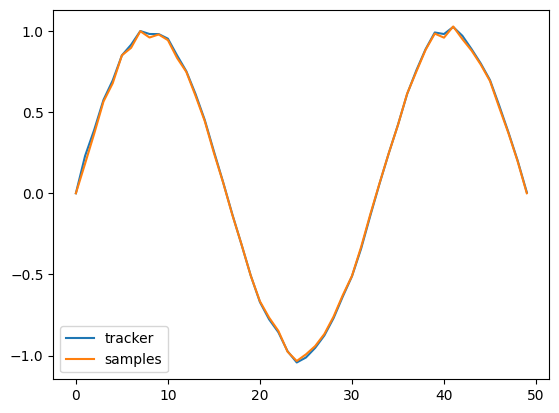

In [83]:
locaterion = [location for location in tracker.locations]
samples_1 = [sample.location for sample in samples]
plt.plot(locaterion, label="tracker")
plt.plot(samples_1, label="samples")
plt.legend()
plt.show()